In [1]:
import sys
sys.path.append("..")

In [2]:
from dataclasses import dataclass
from typing import Optional, Union
import logging

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import PauliSumOp, AerPauliExpectation, PauliExpectation
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector

In [2]:
from src.expectation import Expectation
from src.fidelity import Fidelity

from src.gradients import ExpectationParameterShift, FidelityParameterShift
from src.gradients import ExpectationReverse, FidelityReverse

from experiments.models.heisenline import get_model
from src.dual import DualITE

In [37]:
class GradientDescent:
    """Specialized GD for our fidelity problem."""
    
    def __init__(self, maxiter=100, learning_rate=0.01, timestep_normalization=True, losstol=1e-5, gradtol=1e-5):
        self.maxiter = maxiter
        self.learning_rate = learning_rate
        self.timestep_normalization = timestep_normalization
        self.losstol = losstol
        self.gradtol = gradtol
        
    def check_termination(self, losses, gradients):
        state = ""
        if len(losses) > 1:
            state += f"lossdiff: {np.abs(losses[-1] - losses[-2])} "
            if np.abs(losses[-1] - losses[-2]) <= self.losstol:
                print("Reached losstol at k =", len(losses))
                return True
        
        state += f"gradnorm: {np.linalg.norm(gradients[-1])}"
        if np.linalg.norm(gradients[-1]) <= self.gradtol:
            print("Reached gradtol at k =", len(gradients))
            return True
    
        print(state, end="\r")
        
        return False
        
    def minimize(self, theta, dt, x0, expectation_gradient, fidelity, fidelity_gradient):
        energy_gradient = 0.5 * expectation_gradient.compute(theta)
        xs = [x0]
        losses = []
        gradients = []
        scs = []
        
        for _ in range(self.maxiter):
            x = xs[-1]
            sc = 0.5 * energy_gradient.dot(xs[-1])
            
            infid = 1 - fidelity.evaluate(theta, theta + x)
            loss = energy_gradient.dot(x) + 0.5 / dt * infid
            
            fid_derivative = fidelity_gradient.compute(theta, theta + x)
            gradient = energy_gradient - 0.5 / dt * fid_derivative

            if self.timestep_normalization:
                gradient *= dt
                loss *= dt
                sc *= dt 
                
            losses.append(loss)
            gradients.append(gradient)
            xs.append(x - self.learning_rate * gradient)
            scs.append(sc)
            
            if self.check_termination(losses, gradients):
                break
            
        return xs[-1], xs, losses, gradients, scs

In [24]:
class CG:
    def __init__(self, maxiter=100, losstol=1e-5, gradtol=1e-3):
        self.maxiter = maxiter
        self.gradtol = gradtol  # if norm of residual is below this, stop
        self.losstol = losstol
        
    def check_termination(self, losses, residuals):
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) <= self.losstol:
            print("Reached losstol at k =", len(losses))
            return True
        
        if np.linalg.norm(residuals[-1]) <= self.gradtol:
            print("Reached gradtol at k =", len(losses))
            return True
        
        return False
        
    def minimize(self, theta, dt, x0, expectation_gradient, fidelity, fidelity_gradient):
        energy_gradient = 0.5 * dt * expectation_gradient.compute(theta)
        xs = [x0]
        losses = []
        scs = []
        
        fid_derivative = fidelity_gradient.compute(theta, theta + x0)
        residuals = [-(energy_gradient - 0.5 * fid_derivative)]
        basis_vectors = [residuals[-1]]
        coeffs = []
        
        if self.check_termination(losses, residuals):
            print("Stopped immediately!")
            return x0, xs, losses, residuals, scs
        
        for k in range(self.maxiter):
            print(f"Iteration {k+1}/{self.maxiter}", end="\r")
            rk = residuals[-1]
            pk = basis_vectors[-1]
            
            coeffs.append(rk.dot(rk) / fidelity.evaluate(theta, theta + pk))
            xs.append(xs[-1] + coeffs[-1] * basis_vectors[-1])
            
            fid_derivative = fidelity_gradient.compute(theta, theta + xs[-1])
            residuals.append(-(energy_gradient - 0.5 * fid_derivative))
            
            bk = residuals[-1].dot(residuals[-1]) / rk.dot(rk)
            basis_vectors.append(residuals[-1] + bk * basis_vectors[-1])
            
            losses.append(
                energy_gradient.dot(xs[-1]) + 0.5 * (1 - fidelity.evaluate(theta, theta + xs[-1]))
            )
            scs.append(0.5 * energy_gradient.dot(xs[-1]))
            
            if self.check_termination(losses, residuals):
                print("Stopped at k =", k)
                break
            
        return xs[-1], xs, losses, residuals, scs

In [6]:
class BFGS:
    """Specialized BFGS for our fidelity problem."""
    
    def __init__(self, timestep_normalization=True):
        self.timestep_normalization = timestep_normalization
        
    def minimize(self, theta, dt, x0, expectation_gradient, fidelity, fidelity_gradient):
        energy_gradient = 0.5 * expectation_gradient.compute(theta)

        def loss(x):            
            infid = 1 - fidelity.evaluate(theta, theta + x)
            res = energy_gradient.dot(x) + 0.5 / dt * infid
            if self.timestep_normalization:
                res *= dt
            return res
        
        result = L_BFGS_B().minimize(loss, x0)
        
        sc = 0.5 * energy_gradient.dot(result.x)
        if self.timestep_normalization:
            sc *= dt
        return result.x, [result.x], [result.fun], [None], [sc]

In [38]:
@dataclass
class DualITEResult:
    times: list
    parameters: list
    energies: list

    # history attributes
    thetas: list
    losses: list
    gradients: list
    scs: list


class DualITE:
    """Imaginary time evolution using the QNG minimization formulation."""

    def __init__(
        self,
        ansatz,
        initial_parameters,
        expectation,
        fidelity,
        expectation_gradient = None,
        fidelity_gradient = None,
        norm_factor = 1,
        arccos = False,
        optimizer = None,
        warmstart = True,
    ):
        """
        Args:
            ansatz: The ansatz circuit.
            expectation: The expectation converter to use for the basis transformation.
            fidelity: The fidelity of the two quantum states.
            expectation_gradient: The expectation gradient.
            fidelity_gradient: The fidelity gradient.
            norm_factor: Add the norm of the update step to the loss with this factor.
            arccos: Use arccos instead of 1 - fidelity.
            optimizer: An optimizer callable, taking a loss_and_gradient and initial point.
            warmstart: If True use the gradient of the last iteration as initial step.
                If a vector, this vector is used as first initial guess and then the other
                steps are warmstarted. If False a zero vector is used as initial guess.
        """
        self.ansatz = ansatz
        self.initial_parameters = initial_parameters
        self.expectation = expectation
        self.fidelity = fidelity

        self.expectation.circuit = ansatz
        self.fidelity.right_circuit = ansatz
        self.fidelity.left_circuit = ansatz

        if expectation_gradient is None:
            expectation_gradient = ExpectationParameterShift()

        expectation_gradient.expectation = self.expectation
        self.expectation_gradient = expectation_gradient

        if fidelity_gradient is None:
            fidelity_gradient = FidelityParameterShift()

        fidelity_gradient.fidelity = self.fidelity
        self.fidelity_gradient = fidelity_gradient

        self.norm_factor = norm_factor
        self.arccos = arccos

        if optimizer is None:
            optimizer = GradientDescent(maxiter=300, learning_rate=0.01)

        self.optimizer = optimizer

        self.warmstart = warmstart
        
    def step(self, dt: float, theta: np.ndarray, x0: Optional[np.ndarray] = None):
        """Perform a single step of the time evolution.

        Args:
            dt: The time step.
            theta: The current parameters.
            x0: The point at which to start the optimization (0 per default).

        Returns:
            The new parameters, along with: all parameters, all losses and all gradient norms of
            the optimization.
        """
        if x0 is None:
            x = 0.01 * np.ones_like(theta)
        else:
            x = x0

        x, xs, losses, gradients, sc = self.optimizer(
            theta, dt, x, self.expectation_gradient, self.fidelity, self.fidelity_gradient
        )

        thetas = [theta + x_i for x_i in xs]
        return theta + x, thetas, losses, gradients, sc

    def evolve(self, hamiltonian: PauliSumOp, final_time: float, timestep: float) -> DualITEResult:
        """Evolve the ansatz circuit for a given Hamiltonian.

        Args:
            hamiltonian: The Hamiltonian to evolve under.
            final_time: The final time.
            timestep: The timestep.

        Returns:
            The result of the evolution.
        """
        self.expectation.hamiltonian = hamiltonian
        energies = [self.expectation.evaluate(self.initial_parameters)]
        parameters = [self.initial_parameters]

        thetas = []
        losses = []
        gradients = []
        scs = []

        num_timesteps = int(np.ceil(final_time / timestep))
        times = np.linspace(0, final_time, num_timesteps + 1).tolist()

        if isinstance(self.warmstart, np.ndarray):
            x0 = self.warmstart
        else:
            x0 = 0.01 * np.ones(self.initial_parameters.size)

        for i in range(num_timesteps):
            print(f"Iteration {i+1}/{num_timesteps}")
            next_theta, thetas_i, losses_i, gradients_i, scs_i = self.step(timestep, parameters[-1], x0)

            if self.warmstart is not False:  # to cover the case of np.ndarray
                x0 = next_theta - parameters[-1]

            parameters.append(next_theta)
            energies.append(self.expectation.evaluate(next_theta))

            thetas.append(thetas_i)
            losses.append(losses_i)
            gradients.append(gradients_i)
            scs.append(scs_i)

        return DualITEResult(times, parameters, energies, thetas, losses, gradients, scs)


In [141]:
hamiltonian, circuit, initial_parameters = get_model(num_sites=5, J=0.25, g=-1, reps=6, periodic=True)

In [132]:
circuit.num_parameters

56

In [133]:
print(circuit.decompose().draw())

     ┌──────────┐┌──────────┐      ┌──────────┐┌───────────┐                  »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■───┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├───────────────■──»
     ├──────────┤├──────────┤┌─┴─┐ └──────────┘└┬──────────┤┌───────────┐┌─┴─┐»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├──────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├┤ X ├»
     ├──────────┤├──────────┤└───┘    ┌─┴─┐    ┌┴──────────┤├───────────┤└───┘»
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├──■──────┤ X ├────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├──■──»
     ├──────────┤├──────────┤┌─┴─┐┌───┴───┴───┐├───────────┤└───────────┘┌─┴─┐»
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─────────────┤ X ├»
     └──────────┘└──────────┘└───┘└───────────┘└───────────┘             └───┘»
«     ┌───────────┐┌───────────┐                  ┌───────────┐┌───────────┐»
«q_0: ┤ Ry(θ[16]) ├┤ Rz(θ[20]) ├───────────────■──┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├»
«     └───────────┘├───────────┤┌───────────┐┌─┴─┐└───────────┘├───────────┤»
«q_1: ──────■──────┤ Ry(θ[17]) ├┤ Rz(θ[21]) ├┤

In [134]:
backend = AerSimulator(method="statevector")
expectation_converter = AerPauliExpectation()
shots = None
expectation_gradient = ExpectationReverse()
fidelity_gradient = FidelityReverse()
expectation = Expectation(backend, expectation_converter, hamiltonian, shots=shots)
fidelity = Fidelity(backend, expectation_converter, shots=shots)

In [135]:
def num_iterations(result):
    """Number of iteration steps."""
    thetas = result.thetas if isinstance(result, DualITEResult) else result["thetas"]
    return np.array([len(thetas_i) for thetas_i in thetas])

In [136]:
def energy_errors(exact, result):
    return np.abs(exact.energies - result.energies)

In [137]:
def fidelities(exact, result):
    return [
        np.dot(np.conj(ref), Statevector(circuit.bind_parameters(theta)))
        for ref, theta in zip(exact.parameters, result.parameters)
    ]

### Exact reference

In [354]:
initial_state = Statevector(circuit.bind_parameters(initial_parameters))
initial_statevector = initial_state.data
hamiltonian_matrix = hamiltonian.to_matrix()

times = [0]
energies = [initial_state.expectation_value(hamiltonian_matrix)]
states = [initial_statevector]
final_time = 1
timestep = 0.01

while times[-1] < final_time:
#     print(f"Time {times[-1]}/{final_time}")
    times.append(times[-1] + timestep)
    statevector = sc.linalg.expm(-times[-1] * hamiltonian_matrix).dot(initial_statevector)
    statevector /= np.linalg.norm(statevector)
    energies.append(Statevector(statevector).expectation_value(hamiltonian_matrix))
    states.append(statevector)

exact = DualITEResult(times, states, energies, [], [], [], [])

## Gradient descent

### no stop

In [424]:
gd = GradientDescent(100, 0.1, True, losstol=0, gradtol=0)

In [425]:
algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=False,
    optimizer=gd.minimize,
    timestep_normalization=True,
    norm_factor=0,
)

In [426]:
gd100_nostop = algo.evolve(hamiltonian, final_time=1, timestep=0.01)

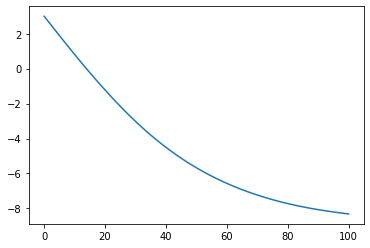

In [427]:
plt.plot(gd100_nostop.energies)
# plt.plot(exact.energies)

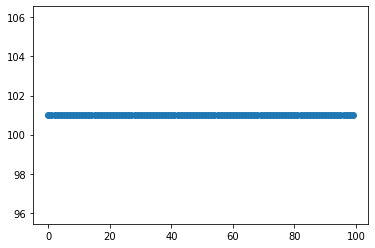

In [345]:
plt.plot(num_iterations(gd100_nostop), "o", ls="")

### with stopping

In [39]:
gd = GradientDescent(100, 0.1, True, losstol=1e-4 * 0.01, gradtol=1e-3 * 0.01)

In [40]:
algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=False,
    optimizer=gd.minimize,
    norm_factor=0,
)

In [41]:
gd100_stop = algo.evolve(hamiltonian, final_time=1, timestep=0.01)

Iteration 1/100
Reached losstol at k = 90883e-06 gradnorm: 0.0031118228720414535
Iteration 2/100
Reached losstol at k = 90442e-06 gradnorm: 0.0031119815400726413
Iteration 3/100
Reached losstol at k = 90156e-06 gradnorm: 0.0031242736536485874
Iteration 4/100
Reached losstol at k = 90155e-06 gradnorm: 0.0031479389455447464
Iteration 5/100
Reached losstol at k = 90756e-06 gradnorm: 0.0031801728735027493
Iteration 6/100
Reached losstol at k = 91327e-06 gradnorm: 0.0031384662806855567
Iteration 7/100
Reached losstol at k = 91009e-06 gradnorm: 0.0031755170183514847
Iteration 8/100
Reached losstol at k = 92353e-06 gradnorm: 0.0031325520653553953
Iteration 9/100
Reached losstol at k = 92979e-06 gradnorm: 0.0031626293564744213
Iteration 10/100
Reached losstol at k = 93349e-06 gradnorm: 0.0031113313405023942
Iteration 11/100
Reached losstol at k = 93945e-06 gradnorm: 0.0031321946434644323
Iteration 12/100
Reached losstol at k = 9336e-06 gradnorm: 0.00314970824729207375
Iteration 13/100
Reached 

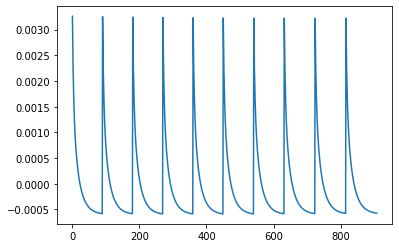

In [42]:
plt.plot(sum(gd100_stop.losses[:10], []))

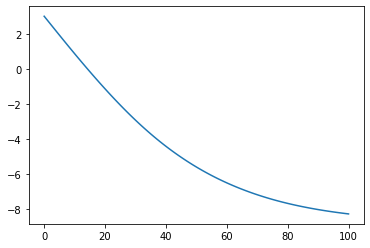

In [43]:
plt.plot(gd100_stop.energies)

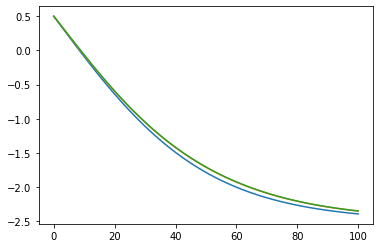

In [385]:
plt.plot(exact.energies)
plt.plot(gd100_nostop.energies)
plt.plot(gd100_stop.energies)

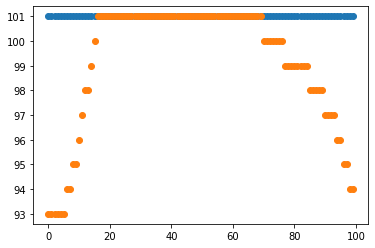

In [384]:
plt.plot(num_iterations(gd100_nostop), "o", ls="")
plt.plot(num_iterations(gd100_stop), "o", ls="")

### warmstart + stop

In [163]:
hamiltonian, circuit, initial_parameters = get_model(num_sites=10, J=0.25, g=-1, reps=6, periodic=True)

In [164]:
gd = GradientDescent(100, 0.1, True, losstol=1e-4 * 0.01, gradtol=1e-3 * 0.01)

algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=True,
    optimizer=gd.minimize,
    norm_factor=0,
)

In [165]:
gd100_ws_stop = algo.evolve(hamiltonian, final_time=1, timestep=0.01)

Iteration 1/100
Reached losstol at k = 84318e-06 gradnorm: 0.0031642041597585637
Iteration 2/100
Reached losstol at k = 25608367
Iteration 3/100
Reached losstol at k = 26362525
Iteration 4/100
Reached losstol at k = 56923e-06 gradnorm: 0.0031123317174177683
Iteration 5/100
Reached losstol at k = 73602e-06 gradnorm: 0.0031180624424805904
Iteration 6/100
Reached losstol at k = 83819e-06 gradnorm: 0.0031247286695548455
Iteration 7/100
Reached losstol at k = 82044e-06 gradnorm: 0.0031743800541829173
Iteration 8/100
Reached losstol at k = 92722e-06 gradnorm: 0.0031439046321765827
Iteration 9/100
Reached losstol at k = 99218e-06 gradnorm: 0.0031191556584342823
Iteration 10/100
Reached losstol at k = 89324e-06 gradnorm: 0.0031833673767345027
Iteration 11/100
Reached losstol at k = 9224e-06 gradnorm: 0.00312354553532083867
Iteration 12/100
Reached losstol at k = 84903e-06 gradnorm: 0.0031560243082841897
Iteration 13/100
Reached losstol at k = 88124e-06 gradnorm: 0.0031611178287720442
Iteration

In [166]:
np.save("10q_gd100_ws_stop.npy", gd100_ws_stop)

In [51]:
exact = np.load("../data/heisencomb/exact.npy", allow_pickle=True).item()

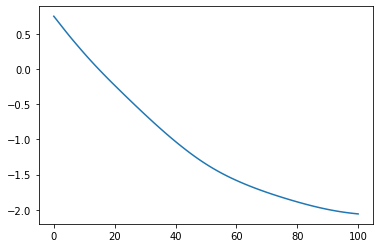

In [101]:
# plt.plot(exact["energies"][:100])
# plt.plot(gd100_stop.energies)
plt.plot(gd100_ws_stop.energies)

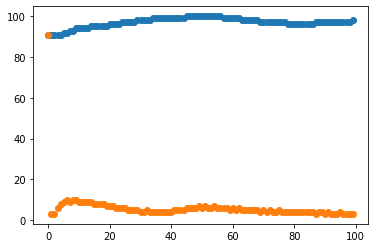

In [49]:
# plt.plot(num_iterations(gd100_nostop), "o", ls="")
plt.plot(num_iterations(gd100_stop), "o", ls="")
plt.plot(num_iterations(gd100_ws_stop), "o", ls="")

In [55]:
np.save("12q_gd100_stop.npy", gd100_stop)

In [56]:
np.save("12q_gd100_ws_stop.npy", gd100_ws_stop)

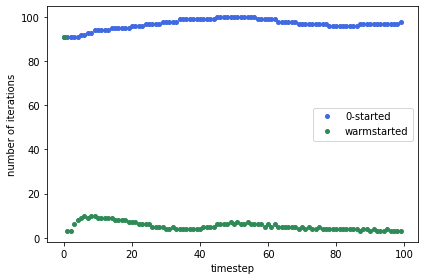

In [85]:
d = circuit.num_parameters
# plt.title("")
# plt.plot(d * (1 + num_iterations(gd100_nostop)), "o", ls="")
plt.plot(num_iterations(gd100_stop), ls="", marker="o", markersize=4, color="royalblue", label=r"0-started")
plt.plot(num_iterations(gd100_ws_stop), ls="", marker="o", markersize=4, color="seagreen", label=r"warmstarted")
plt.xlabel("timestep")
plt.ylabel("number of iterations")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("num_circuits_per_step.pdf")

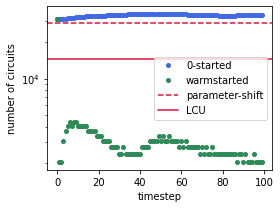

In [90]:
k = 3
d = circuit.num_parameters
# plt.title("")
plt.figure(figsize=(4, 3))
plt.semilogy()
# plt.plot(d * (1 + num_iterations(gd100_nostop)), "o", ls="")
plt.plot(d * (2 * k + 2 * num_iterations(gd100_stop)), ls="", marker="o", markersize=4, color="royalblue", label=r"0-started")
plt.plot(d * (2 * k + 2 * num_iterations(gd100_ws_stop)), ls="", marker="o", markersize=4, color="seagreen", label=r"warmstarted")
plt.axhline(y=d * (d + 1 * 2 * k), color="crimson", ls="--", label="parameter-shift")
plt.axhline(y=d * (d + 7) / 2, color="crimson", label="LCU")
plt.xlabel("timestep")
plt.ylabel("number of circuits")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("num_circuits_per_step.pdf")

In [167]:
num_qubits = list(range(3, 12 + 1))
all_data = [
    np.load(f"{n}q_gd100_ws_stop.npy", allow_pickle=True).item()
    for n in num_qubits
]
all_iterations = [
    num_iterations(data) for data in all_data
]

In [168]:
# first iteration
first_iters = [it[0] for it in all_iterations]

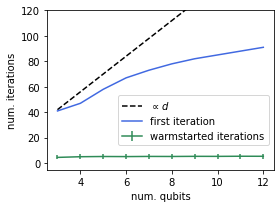

In [215]:
# plt.plot(num_qubits, first_iters)
plt.figure(figsize=(4, 3))
# plt.semilogy()
num_params = 2 * 7 * np.array(num_qubits)
plt.plot(num_qubits, num_params, "k--", label=r"$\propto d$")
plt.plot(num_qubits, first_iters, color="royalblue", label="first iteration")
plt.errorbar(num_qubits, means, yerr=stds, color="seagreen", label="warmstarted iterations")
plt.ylim(top=120)
plt.ylabel("num. iterations")
plt.xlabel("num. qubits")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("iters_vs_size.pdf")

In [183]:
# warmstarted iterations
means = [np.mean(it[1:]) for it in all_iterations]
stds = [np.std(it[1:]) for it in all_iterations]

Text(0.5, 0, 'num. parameters')

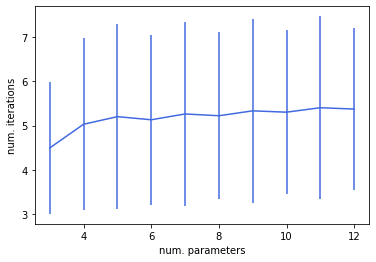

In [192]:
plt.errorbar(num_qubits, means, yerr=stds, color="royalblue")
plt.ylabel("num. iterations")
plt.xlabel("num. parameters")

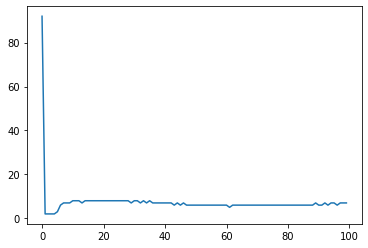

In [14]:
d = np.load("gd100_ws_stop.npy", allow_pickle=True).item()
plt.plot([len(loss) for loss in d["losses"]])

In [15]:
gd100_nostop = np.load("gd100_nostop.npy", allow_pickle=True).item()
gd100_stop = np.load("gd100_stop.npy", allow_pickle=True).item()
gd100_ws_stop = np.load("gd100_ws_stop.npy", allow_pickle=True).item()

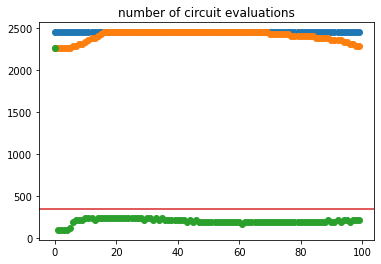

In [20]:
d = 3 * 4 * 2
plt.title("number of circuit evaluations")
plt.plot(d * (1 + num_iterations(gd100_nostop)), "o", ls="")
plt.plot(d * (1 + num_iterations(gd100_stop)), "o", ls="")
plt.plot(d * (1 + num_iterations(gd100_ws_stop)), "o", ls="")
plt.axhline(y=d * (d + 5) / 2, color="tab:red")

In [412]:
# dump
from dataclasses import asdict

np.save("gd100_nostop.npy", asdict(gd100_nostop))
np.save("gd100_stop.npy", asdict(gd100_stop))
np.save("gd100_ws_stop.npy", asdict(gd100_ws_stop))

In [21]:
print("VarQITE:", 100 * d * (d + 5) / 2)
print("GD + ws + stop:", sum(d * (1 + num_iterations(gd100_ws_stop))))

VarQITE: 34800.0
GD + ws + stop: 22392


## Conjugate gradient

In [399]:
gd = CG(200, losstol=1e-5 * 0.01, gradtol=1e-5 * 0.01)

algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=False,
    optimizer=gd.minimize,
    timestep_normalization=True,
    norm_factor=0,
)

In [400]:
cg_stop = algo.evolve(hamiltonian, final_time=1, timestep=0.01)

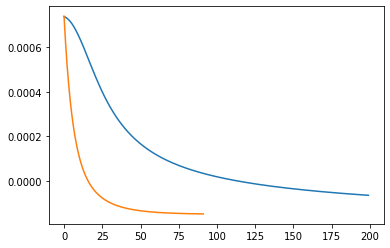

In [409]:
plt.plot(cg_stop.losses[0])
plt.plot(gd100_stop.losses[0])

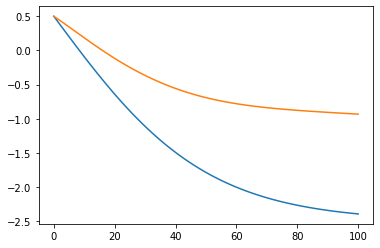

In [402]:
plt.plot(exact.energies)
plt.plot(cg_stop.energies)

### BFGS

In [326]:
gd = BFGS()

In [327]:
algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=False,
    optimizer=gd.minimize,
    timestep_normalization=True,
    norm_factor=0,
)

In [328]:
bfgs_result = algo.evolve(hamiltonian, final_time=1, timestep=0.01)

-- Warmstarting with initial guess: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


ValueError: too many values to unpack (expected 4)

In [321]:
algo.expectation.hamiltonian = hamiltonian

In [263]:
theta1 = thetas[-1]

In [322]:
_, thetas, losses, gradients, sc = algo.step(dt=0.01, theta=initial_parameters)

Reached losstol at k = 2


In [276]:
_, thetas, losses, gradients, sc = algo.step(dt=0.01, theta=theta1)#, x0=theta1 - initial_parameters)

In [235]:
ws = (thetas[0] - initial_parameters) / 0.01 + 0.1 * (np.random.random(thetas[0].size) - 0.5)

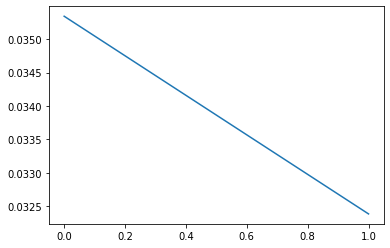

In [323]:
plt.plot([np.linalg.norm(residual) for residual in gradients])

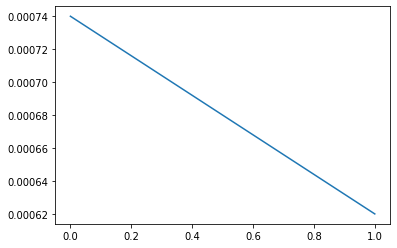

In [324]:
plt.plot(losses)

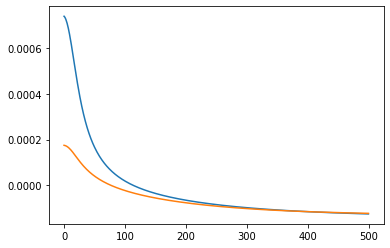

In [297]:
plt.plot(losses)
plt.plot(sc)

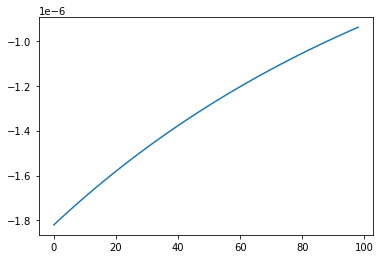

In [153]:
plt.plot(np.diff(losses))

### Conjugate gradient descent

In [ ]:
gd = CG(maxiter=500)